In [23]:
import torch
from torch.autograd import Function

# class DiceCoeff(Function):
#     """Dice coeff for individual examples"""

#     def forward(self, input, target):
#         #self.save_for_backward(input, target)
#         eps = 0.0001
#         b = input.size(0)
#         self.inter = input.view(b,-1) * target.view(b,-1)
#         self.union = torch.sum(input,axis=(1,2,3)) + torch.sum(target,axis=(1,2,3)) + eps

#         t = (2 * self.inter.float() + eps) / self.union.float()
#         return t.mean(0)

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

In [31]:
#两个DICE loss的计算结果一样，推荐使用这个！
import torch.nn as nn
class Dice_loss(nn.Module):
    def __init__(self):
        super(Dice_loss,self).__init__()

    def forward(self,pred,true):
        b = pred.size(0)
        p = pred.view(b,-1)
        t = true.view(b,-1)
        coff = 2*(p*t).sum(1)/(p.sum(1)+t.sum(1))
        loss = 1- coff.mean(0)
        return loss

In [24]:
out = torch.randn((1,1,512,512),dtype=torch.float)
probs = torch.sigmoid(out)
true_mask = torch.randint(0,2,(1,1,512,512)).float()

In [25]:
true_mask[0,...,0,0],out[0,...,0,0],probs[0,...,0,0]

(tensor([0.]), tensor([-0.3699]), tensor([0.4086]))

In [27]:
dl1 = 1.0 - DiceCoeff().forward(probs,true_mask)
dl1

tensor(0.5008)

In [30]:
dl2 = Dice_loss().forward(probs,true_mask)
dl2

tensor(0.5008)

<mark>由此说明两个DICE Loss的计算结果一样！</mark>

-------------------------------

In [135]:
import torch
import torch.nn as nn

class DICEandfocalLoss(nn.Module):
    def __init__(self,device,num_classes=2):
        super().__init__()
        self.device = device
        self.num_classes = num_classes
        

    def forward(self,probs,true_mask):
        #-------------------------multi-class
        # 此时的probs = softmax(logits)，因为是多分类，所以用softmax
        pred = probs>0.5
        classes_points = []
        for i in range(self.num_classes):
            classes_points.append(pred==i)

        
        TP = torch.zeros((self.num_classes),dtype=torch.float32).to(self.device)
        FP = torch.zeros((self.num_classes),dtype=torch.float32).to(self.device)
        FN = torch.zeros((self.num_classes),dtype=torch.float32).to(self.device)
        
        loss_focal = torch.zeros((self.num_classes,),dtype=torch.float32).to(self.device)

        for i in range(self.num_classes):
            #下注释代码为旧的错误代码，之前没有很好的理解论文中ΣN 的意思。新代码理解正确了✔
            #新理解即：Σn p(c) 是指求和 HW平面上所有pixel不管这个类别c是不是argmax @，即@的预测类)
#             TP[i] = ((true_mask*probs)*classes_points[i]).sum(axis=(1,2,3))
#             FN[i] = ((true_mask*(1.0-probs))*classes_points[i]).sum(axis=(1,2,3))
#             FP[i] = (((1.0-true_mask)*probs)*classes_points[i]).sum(axis=(1,2,3))
            TP[i] = (probs[:,i] * true_mask[:,i]).sum(axis=(1,2)).mean()
            FN[i] = ((1.0-probs[:,i]) * true_mask[:,i]).sum(axis=(1,2)).mean()
            FP[i] = (probs[:,i] * (1-true_mask[:,i])).sum(axis=(1,2)).mean()
            #print(FP[i].shape)
            
            loss_focal += (classes_points[i]*(1-probs[:,i].pow(2))*probs[:,i].log()).mean(axis=(0,2,3))
            
        
        
        #print()
        
        alpha = beta = 0.5
        lambaa = 1
        
        # change here：分子分母都*2 && α=β=1，则结果和链接的多分类DICE Loss一致。
        # 分子分母的TP都不乘2 && α=β=0.5，则对应原论文的公式！
        #loss_dice = self.num_classes - (2*TP / (2*TP+alpha*FN+beta*FP)).sum()
        loss_dice = self.num_classes - (TP / (TP+alpha*FN+beta*FP)).sum()
        loss_focal = -loss_focal.sum()
        #这里的focal loss仅支持二分类，而DICE Loss则只支持多分类(看最下测试代码易懂)。
#         loss1 = (true_mask*(1-probs)**2)*torch.log(probs)
#         loss2 = (1-true_mask)*(probs**2)*torch.log(1-probs)
#         loss_focal = (loss1+loss2).mean(axis=(1,2,3)) * lambdaa
#         loss_focal = -loss_focal.mean()
        
        loss = loss_dice.mean()+loss_focal
        #-------------------------multi-class
        
        #-------------------------two-class
        #参考上面cell中的class Dice_loss的forward函数就行了
        #-------------------------multi-class

        '''
            由https://blog.csdn.net/liangjiu2009/article/details/107352164 关于多分类DICE loss的代码(👇)易懂,
            常见的多分类DICE Loss其实就是👇论文公式中，当取α=β=1时，对应的公式。
            所以我这个class的参数self.num_classes=num,其实对应了？？ 
            *所以论文中的公式可以看成常用多分类DICE loss的泛化版，即引入了两个参数α和β来使之适应更多不同的情况。*
            *这有点像那篇通过引入新参数统一了GAP和GMP为一个公式的那个方法 nm*
            @所以结论是，在我毕业设计的这个问题中，我应该使用two-class的loss，而不应该使用multi-class的loss@
            @这也是我计算为什么出错的原因@
        '''
        '''
            # 遍历 channel，得到每个类别的二分类 DiceLoss
            for i in range(C):
                dice_loss = binaryDiceLoss(logits[:, i], target[:, i])
                total_loss += dice_loss.ipynb
        '''
        #虽然叫做DICEandFocalLoss，但是这里为了比较DICE loss部分是否正确，所以最终只返回其中的loss_dice部分
        #focal loss部分已验证正确！见focal_loss.ipynb即可
        return loss_dice.mean()

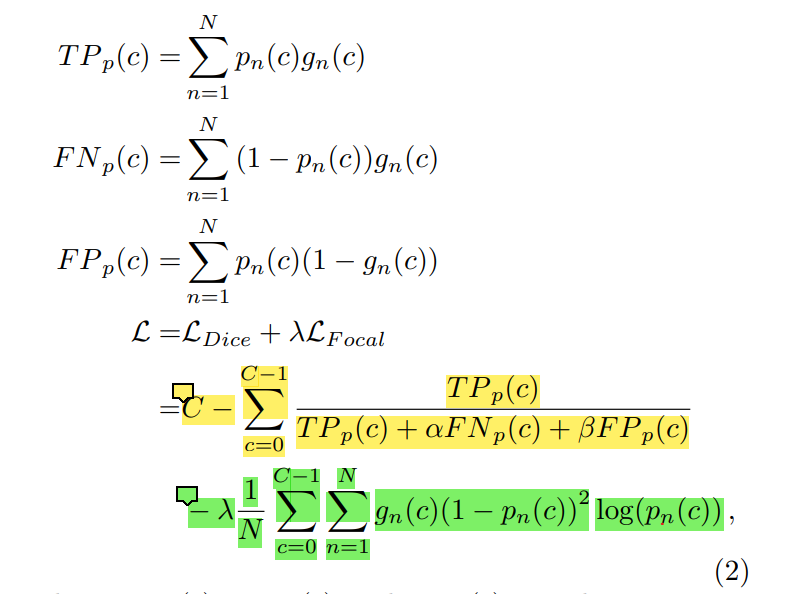
AnatomyNet: Deep Learning for Fast and Fully Automated Whole-volume
Segmentation of Head and Neck Anatomy

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryDiceLoss(nn.Module):
	def __init__(self):
		super(BinaryDiceLoss, self).__init__()
	
	def forward(self, input, targets):
		# 获取每个批次的大小 N
		N = targets.size()[0]
		# 平滑变量
		smooth = 1
		# 将宽高 reshape 到同一纬度
		input_flat = input.view(N, -1)
		targets_flat = targets.view(N, -1)
	
		# 计算交集
		intersection = input_flat * targets_flat 
		N_dice_eff = (2 * intersection.sum(1) + smooth) / (input_flat.sum(1) + targets_flat.sum(1) + smooth)
		# 计算一个批次中平均每张图的损失
		loss = 1 - N_dice_eff.sum() / N
		return loss

    

class MultiClassDiceLoss(nn.Module):
	def __init__(self, weight=None, ignore_index=None, **kwargs):
		super(MultiClassDiceLoss, self).__init__()
		self.weight = weight
		self.ignore_index = ignore_index
		self.kwargs = kwargs
	
	def forward(self, input, target):
		"""
			input tesor of shape = (N, C, H, W)
			target tensor of shape = (N, H, W)
		"""
		# 先将 target 进行 one-hot 处理，转换为 (N, C, H, W)
		nclass = input.shape[1]
		#target = one_hot(target.long(), nclass)

		assert input.shape == target.shape, "predict & target shape do not match"
		
		binaryDiceLoss = BinaryDiceLoss()
		total_loss = 0
		
		# 归一化输出
		logits = F.softmax(input, dim=1)
		C = target.shape[1]
		
		# 遍历 channel，得到每个类别的二分类 DiceLoss
		for i in range(C):
			dice_loss = binaryDiceLoss(logits[:, i], target[:, i])
			total_loss += dice_loss
		
		# 每个类别的平均 dice_loss
		return total_loss


https://blog.csdn.net/liangjiu2009/article/details/107352164 

------------------

<mark>这里的测试表明了我写的DICE Loss也能用到多分类中</mark>

In [50]:
device = torch.device('cpu')

In [118]:
out = torch.randn((4,2,512,512),dtype=torch.float)
probs = torch.nn.functional.softmax(out,dim=1)
true_mask = torch.randint(0,2,(4,2,512,512)).float()

In [124]:
multi_class_dl1 = DICEandfocalLoss(device,2)
mcdl1 = multi_class_dl1(probs,true_mask)
mcdl1

tensor(0.9999)

链接https://blog.csdn.net/liangjiu2009/article/details/107352164 和论文中的loss是等价的！只需要根据“change here”对论文公式做出一些修改就能使其变为DICE LOSS。<br>
这也从另外一个角度说明，论文中的是：C-ΣTP/(TP+FN+FP)并不是DICE LOSS(F1)，而是一种变种！(反正它们做实验发现有效 nm为什么变)

In [125]:
multi_class_dl2 = MultiClassDiceLoss()
mcdl2 = multi_class_dl2(out,true_mask)
mcdl2

tensor(0.9999)

In [128]:
# 按照“change here”修改后
# 上面已经去除了修改，注意。
mcdl1, mcdl2

(tensor(0.9999), tensor(0.9999))